In [1]:
import yahoofinancials

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from datetime import date
from datetime import timedelta

from yahoofinancials import YahooFinancials

from scipy.stats import norm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation

import warnings
warnings.filterwarnings('ignore')

In [2]:
end = '2021-08-03'
start = '2016-07-20'

stock_symbol = 'TCS.NS'

yf = YahooFinancials(stock_symbol)
data = yf.get_historical_price_data(start, end, 'daily')
TCS = pd.DataFrame(data['TCS.NS']['prices'])

df = TCS.dropna()
df

,date,high,low,open,close,volume,adjclose,formatted_date
0,1468986300,1251.250000,1224.074951,1225.000000,1247.474976,2815252.0,1129.042114,2016-07-20
1,1469072700,1259.750000,1232.224976,1244.750000,1253.025024,2527148.0,1134.065430,2016-07-21
2,1469159100,1262.000000,1246.000000,1249.449951,1257.550049,1517216.0,1138.160645,2016-07-22
3,1469418300,1281.599976,1252.900024,1256.000000,1279.474976,1688796.0,1161.004517,2016-07-25
4,1469504700,1284.000000,1266.500000,1279.474976,1276.300049,2311290.0,1158.123901,2016-07-26
...,...,...,...,...,...,...,...,...
1238,1627357500,3210.000000,3161.149902,3200.000000,3182.949951,1121367.0,3182.949951,2021-07-27
1239,1627443900,3204.449951,3132.399902,3188.000000,3197.800049,1660654.0,3197.800049,2021-07-28
1240,1627530300,3225.449951,3190.300049,3200.250000,3195.800049,1731997.0,3195.800049,2021-07-29
1241,1627616700,3223.500000,3162.350098,3219.000000,3167.449951,2999943.0,3167.449951,2021-07-30


In [3]:
df = df[["formatted_date", "close"]]
df.rename(columns={"formatted_date": "ds", "close": "y"}, inplace=True)
df

,ds,y
0,2016-07-20,1247.474976
1,2016-07-21,1253.025024
2,2016-07-22,1257.550049
3,2016-07-25,1279.474976
4,2016-07-26,1276.300049
...,...,...
1238,2021-07-27,3182.949951
1239,2021-07-28,3197.800049
1240,2021-07-29,3195.800049
1241,2021-07-30,3167.449951


In [4]:
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')

Train Test split

In [5]:
cut_date = '2021-06-19'
mask1 = (df['ds'] <= cut_date)
mask2 = (df['ds'] > cut_date)

X_tr = df.loc[mask1]
X_tst = df.loc[mask2]
print("train shape",X_tr.shape)
print("test shape",X_tst.shape)

train shape (1211, 2)
test shape (30, 2)


In [6]:
X_tst.tail

<bound method NDFrame.tail of              ds            y
1213 2021-06-21  3273.100098
1214 2021-06-22  3301.199951
1215 2021-06-23  3261.399902
1216 2021-06-24  3373.600098
1217 2021-06-25  3380.800049
1218 2021-06-28  3336.750000
1219 2021-06-29  3340.850098
1220 2021-06-30  3345.750000
1221 2021-07-01  3341.500000
1222 2021-07-02  3325.449951
1223 2021-07-05  3321.000000
1224 2021-07-06  3262.300049
1225 2021-07-07  3274.949951
1226 2021-07-08  3258.500000
1227 2021-07-09  3208.149902
1228 2021-07-12  3193.100098
1229 2021-07-13  3187.550049
1230 2021-07-14  3214.550049
1231 2021-07-15  3202.949951
1232 2021-07-16  3194.800049
1233 2021-07-19  3184.600098
1234 2021-07-20  3205.800049
1235 2021-07-22  3216.350098
1236 2021-07-23  3212.850098
1237 2021-07-26  3197.550049
1238 2021-07-27  3182.949951
1239 2021-07-28  3197.800049
1240 2021-07-29  3195.800049
1241 2021-07-30  3167.449951
1242 2021-08-02  3219.399902>

Install library

In [7]:
from prophet import Prophet

Model Building

In [8]:
import tensorflow as tf
tf.random.set_seed(seed=1)
model =Prophet(changepoint_prior_scale= 0.2, seasonality_prior_scale=0.01, seasonality_mode='multiplicative',changepoint_range=0.9) 
model.fit(X_tr)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
future = model.make_future_dataframe(periods=31, freq='B')
forecast = model.predict(future)

In [10]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2016-07-20,1351.382872,1249.167485,1409.309559,1351.382872,1351.382872,-0.015435,-0.015435,-0.015435,0.002870,0.002870,0.002870,-0.018304,-0.018304,-0.018304,0.0,0.0,0.0,1330.524729
1,2016-07-21,1349.640579,1237.008418,1404.555433,1349.640579,1349.640579,-0.016014,-0.016014,-0.016014,0.002120,0.002120,0.002120,-0.018133,-0.018133,-0.018133,0.0,0.0,0.0,1328.027794
2,2016-07-22,1347.898286,1240.129654,1402.991890,1347.898286,1347.898286,-0.017601,-0.017601,-0.017601,0.000353,0.000353,0.000353,-0.017954,-0.017954,-0.017954,0.0,0.0,0.0,1324.174526
3,2016-07-25,1342.671408,1241.434739,1403.014799,1342.671408,1342.671408,-0.015660,-0.015660,-0.015660,0.001776,0.001776,0.001776,-0.017436,-0.017436,-0.017436,0.0,0.0,0.0,1321.645503
4,2016-07-26,1340.929115,1238.863987,1396.986763,1340.929115,1340.929115,-0.015097,-0.015097,-0.015097,0.002193,0.002193,0.002193,-0.017290,-0.017290,-0.017290,0.0,0.0,0.0,1320.685696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,2021-07-27,3317.283345,3180.451057,3355.213674,3295.689102,3336.623805,-0.015000,-0.015000,-0.015000,0.002193,0.002193,0.002193,-0.017193,-0.017193,-0.017193,0.0,0.0,0.0,3267.524100
1238,2021-07-28,3319.331861,3182.219992,3362.183708,3296.276931,3339.359057,-0.014215,-0.014215,-0.014215,0.002870,0.002870,0.002870,-0.017084,-0.017084,-0.017084,0.0,0.0,0.0,3272.148361
1239,2021-07-29,3321.380377,3185.701272,3353.629355,3296.933081,3342.388691,-0.014881,-0.014881,-0.014881,0.002120,0.002120,0.002120,-0.017000,-0.017000,-0.017000,0.0,0.0,0.0,3271.955684
1240,2021-07-30,3323.428893,3177.289692,3356.692292,3297.387167,3345.246614,-0.016589,-0.016589,-0.016589,0.000353,0.000353,0.000353,-0.016943,-0.016943,-0.016943,0.0,0.0,0.0,3268.296056


Actual vs Prediction

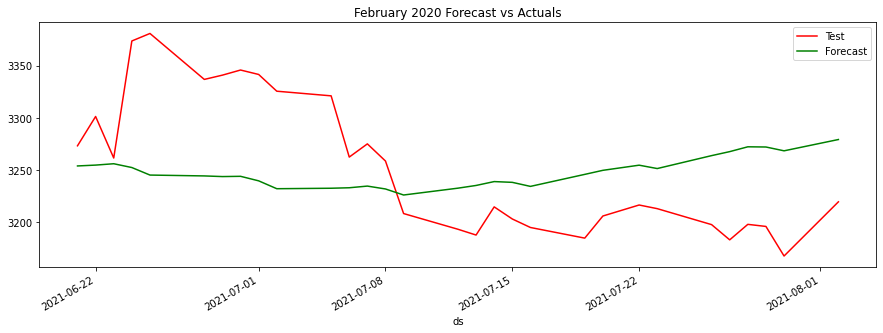

In [11]:
X_tst_forecast = model.predict(X_tst)

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
X_tst_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('February 2020 Forecast vs Actuals')
plt.show()

<AxesSubplot:xlabel='ds'>

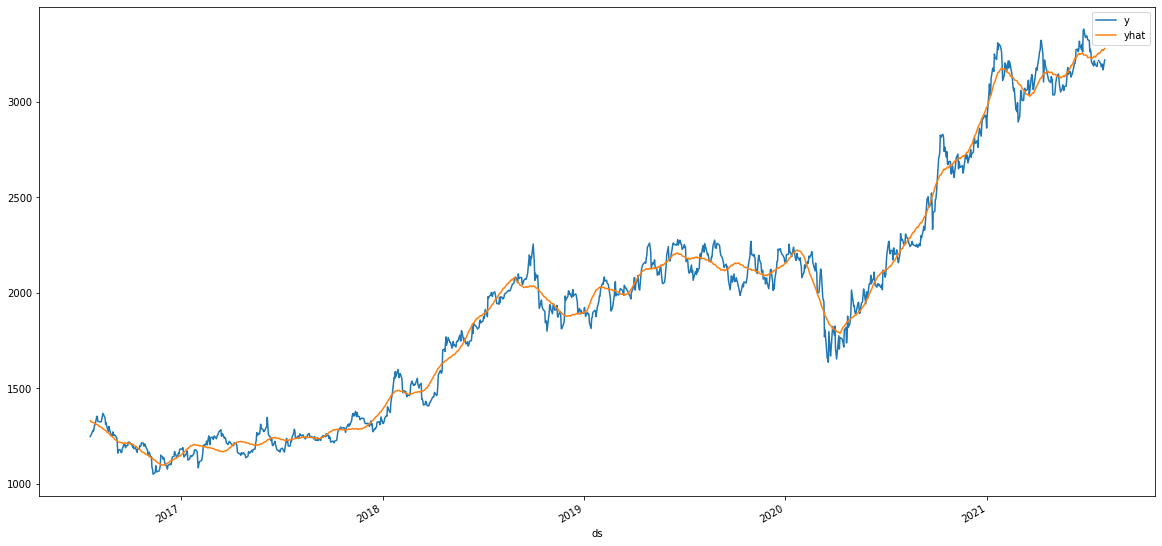

In [12]:
pd.concat([df.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1).plot()

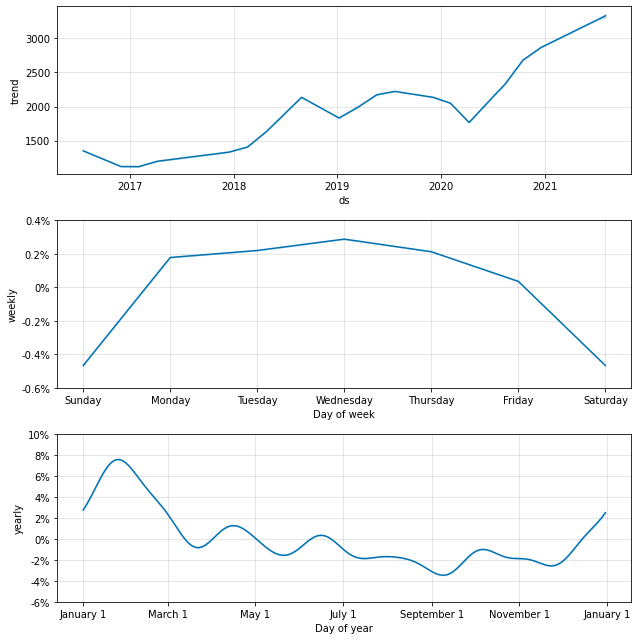

In [13]:
fig2 = model.plot_components(forecast)

MSE

In [14]:
from sklearn.metrics import mean_squared_error


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_squared_error(X_tst['y'],X_tst_forecast['yhat'])


4900.276800267072

MAPE

In [15]:
mape = mean_absolute_percentage_error(X_tst['y'],X_tst_forecast['yhat'])
print("MAPE",round(mape,4))

MAPE 1.8835


Next 30 Days Prediction

In [16]:
df

,ds,y
0,2016-07-20,1247.474976
1,2016-07-21,1253.025024
2,2016-07-22,1257.550049
3,2016-07-25,1279.474976
4,2016-07-26,1276.300049
...,...,...
1238,2021-07-27,3182.949951
1239,2021-07-28,3197.800049
1240,2021-07-29,3195.800049
1241,2021-07-30,3167.449951


In [17]:
#make_future_dataframe(m, periods, freq = "day", include_history = TRUE)

future = model.make_future_dataframe(periods=30)
forecast_30 = model.predict(future)
forecast_30

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2016-07-20,1351.382872,1249.436564,1405.752815,1351.382872,1351.382872,-0.015435,-0.015435,-0.015435,0.002870,0.002870,0.002870,-0.018304,-0.018304,-0.018304,0.0,0.0,0.0,1330.524729
1,2016-07-21,1349.640579,1251.777046,1411.494390,1349.640579,1349.640579,-0.016014,-0.016014,-0.016014,0.002120,0.002120,0.002120,-0.018133,-0.018133,-0.018133,0.0,0.0,0.0,1328.027794
2,2016-07-22,1347.898286,1249.300469,1401.112186,1347.898286,1347.898286,-0.017601,-0.017601,-0.017601,0.000353,0.000353,0.000353,-0.017954,-0.017954,-0.017954,0.0,0.0,0.0,1324.174526
3,2016-07-25,1342.671408,1232.772454,1411.749784,1342.671408,1342.671408,-0.015660,-0.015660,-0.015660,0.001776,0.001776,0.001776,-0.017436,-0.017436,-0.017436,0.0,0.0,0.0,1321.645503
4,2016-07-26,1340.929115,1239.534668,1399.564517,1340.929115,1340.929115,-0.015097,-0.015097,-0.015097,0.002193,0.002193,0.002193,-0.017290,-0.017290,-0.017290,0.0,0.0,0.0,1320.685696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1236,2021-07-14,3290.652638,3151.063490,3320.072459,3283.551122,3297.807495,-0.015756,-0.015756,-0.015756,0.002870,0.002870,0.002870,-0.018626,-0.018626,-0.018626,0.0,0.0,0.0,3238.804900
1237,2021-07-15,3292.701154,3150.224335,3326.047041,3284.920229,3301.337453,-0.016592,-0.016592,-0.016592,0.002120,0.002120,0.002120,-0.018712,-0.018712,-0.018712,0.0,0.0,0.0,3238.068349
1238,2021-07-16,3294.749670,3148.011700,3326.975036,3285.984422,3304.615571,-0.018379,-0.018379,-0.018379,0.000353,0.000353,0.000353,-0.018732,-0.018732,-0.018732,0.0,0.0,0.0,3234.195470
1239,2021-07-17,3296.798186,3131.903881,3305.323904,3286.915879,3307.938545,-0.023353,-0.023353,-0.023353,-0.004656,-0.004656,-0.004656,-0.018697,-0.018697,-0.018697,0.0,0.0,0.0,3219.808846


Train Test split

In [18]:
cut_date = '2021-07-19'
mask1 = (df['ds'] <= cut_date)
mask2 = (df['ds'] > cut_date)

X_tr = df.loc[mask1]
X_tst = df.loc[mask2]
print("train shape",X_tr.shape)
print("test shape",X_tst.shape)

train shape (1232, 2)
test shape (9, 2)


In [19]:
import tensorflow as tf
tf.random.set_seed(seed=1)
model =Prophet(changepoint_prior_scale= 0.4, n_changepoints=100, seasonality_mode='multiplicative') 
model.fit(X_tr)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [20]:
future = model.make_future_dataframe(periods=9, freq='C')
forecast = model.predict(future)


In [21]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2016-07-20,309.182099,1223.526423,1323.764744,309.182099,309.182099,3.129558,3.129558,3.129558,3.358685,3.358685,3.358685,-0.229127,-0.229127,-0.229127,0.0,0.0,0.0,1276.785278
1,2016-07-21,310.223824,1229.086224,1327.668935,310.223824,310.223824,3.124537,3.124537,3.124537,3.357193,3.357193,3.357193,-0.232656,-0.232656,-0.232656,0.0,0.0,0.0,1279.529676
2,2016-07-22,311.265548,1231.154828,1331.478935,311.265548,311.265548,3.115121,3.115121,3.115121,3.350948,3.350948,3.350948,-0.235827,-0.235827,-0.235827,0.0,0.0,0.0,1280.895498
3,2016-07-25,314.390722,1246.309665,1347.821219,314.390722,314.390722,3.110046,3.110046,3.110046,3.353835,3.353835,3.353835,-0.243790,-0.243790,-0.243790,0.0,0.0,0.0,1292.160283
4,2016-07-26,315.432447,1245.657942,1344.855100,315.432447,315.432447,3.112044,3.112044,3.112044,3.358180,3.358180,3.358180,-0.246135,-0.246135,-0.246135,0.0,0.0,0.0,1297.072227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1236,2021-07-26,786.706983,3178.181253,3289.956272,785.256240,788.767579,3.108279,3.108279,3.108279,3.353835,3.353835,3.353835,-0.245556,-0.245556,-0.245556,0.0,0.0,0.0,3232.012092
1237,2021-07-27,787.370174,3184.168402,3290.493160,784.998906,790.275624,3.110322,3.110322,3.110322,3.358180,3.358180,3.358180,-0.247857,-0.247857,-0.247857,0.0,0.0,0.0,3236.345317
1238,2021-07-28,788.033364,3183.214170,3292.643563,785.054363,791.961118,3.108535,3.108535,3.108535,3.358685,3.358685,3.358685,-0.250150,-0.250150,-0.250150,0.0,0.0,0.0,3237.662793
1239,2021-07-29,788.696555,3181.390368,3292.426535,784.751391,793.953148,3.104706,3.104706,3.104706,3.357193,3.357193,3.357193,-0.252487,-0.252487,-0.252487,0.0,0.0,0.0,3237.367504


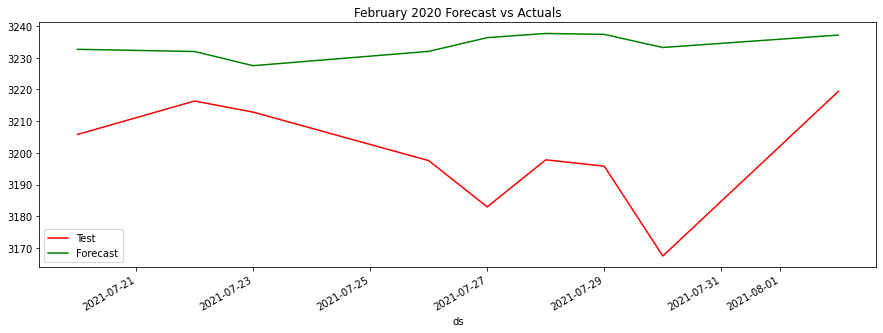

In [22]:
X_tst_forecast = model.predict(X_tst)

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
X_tst_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('February 2020 Forecast vs Actuals')
plt.show()

<AxesSubplot:xlabel='ds'>

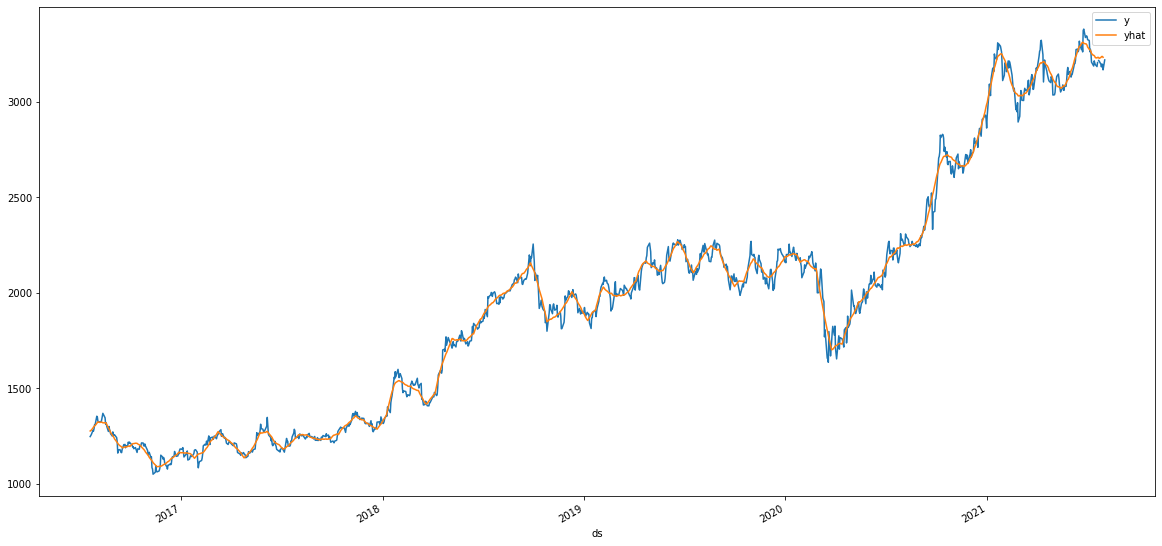

In [23]:
pd.concat([df.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1).plot()

In [24]:
from sklearn.metrics import mean_squared_error


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_squared_error(X_tst['y'],X_tst_forecast['yhat'])


1464.40327294466

In [25]:
mape = mean_absolute_percentage_error(X_tst['y'],X_tst_forecast['yhat'])
print("MAPE",round(mape,4))

MAPE 1.079


In [26]:
future = model.make_future_dataframe(periods=30)
forecast_30 = model.predict(future)
forecast_30

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2016-07-20,309.182099,1230.626835,1328.951608,309.182099,309.182099,3.129558,3.129558,3.129558,3.358685,3.358685,3.358685,-0.229127,-0.229127,-0.229127,0.0,0.0,0.0,1276.785278
1,2016-07-21,310.223824,1229.953732,1328.246163,310.223824,310.223824,3.124537,3.124537,3.124537,3.357193,3.357193,3.357193,-0.232656,-0.232656,-0.232656,0.0,0.0,0.0,1279.529676
2,2016-07-22,311.265548,1232.390383,1331.797197,311.265548,311.265548,3.115121,3.115121,3.115121,3.350948,3.350948,3.350948,-0.235827,-0.235827,-0.235827,0.0,0.0,0.0,1280.895498
3,2016-07-25,314.390722,1240.476710,1339.885731,314.390722,314.390722,3.110046,3.110046,3.110046,3.353835,3.353835,3.353835,-0.243790,-0.243790,-0.243790,0.0,0.0,0.0,1292.160283
4,2016-07-26,315.432447,1248.396560,1347.238614,315.432447,315.432447,3.112044,3.112044,3.112044,3.358180,3.358180,3.358180,-0.246135,-0.246135,-0.246135,0.0,0.0,0.0,1297.072227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,2021-08-14,799.307605,-6394.640879,-5966.142435,774.033544,828.830637,-8.702283,-8.702283,-8.702283,-8.389421,-8.389421,-8.389421,-0.312862,-0.312862,-0.312862,0.0,0.0,0.0,-6156.493079
1258,2021-08-15,799.970796,-6419.642886,-5945.798302,772.897165,832.444212,-8.706833,-8.706833,-8.706833,-8.389421,-8.389421,-8.389421,-0.317412,-0.317412,-0.317412,0.0,0.0,0.0,-6165.241038
1259,2021-08-16,800.633987,3100.164631,3376.623574,771.435880,834.661209,3.032006,3.032006,3.032006,3.353835,3.353835,3.353835,-0.321830,-0.321830,-0.321830,0.0,0.0,0.0,3228.160695
1260,2021-08-17,801.297177,3096.292909,3377.508788,770.327858,836.155679,3.032111,3.032111,3.032111,3.358180,3.358180,3.358180,-0.326069,-0.326069,-0.326069,0.0,0.0,0.0,3230.919175


In [27]:
# import json
# from prophet.serialize import model_to_json, model_from_json

# with open('serialized_model.json', 'w') as fout:
#     json.dump(model_to_json(m), fout)  # Save model

# with open('serialized_model.json', 'r') as fin:
#     m = model_from_json(json.load(fin))  # Load model